In [1]:
import torch
from nlp_fast_unlearning.utils import prepare_dbpedia, build_noisy_dl, ensure_deterministic, DEVICE, BATCH_SIZE
from nlp_fast_unlearning.baseline_model import TextClassificationModel

_, _, _, dbpedia_vocab = prepare_dbpedia(for_baseline_only=True)

vocab_size = dbpedia_vocab.vocab_size

baseline_name = "DBpedia_baseline.pt"
unlearning_model = TextClassificationModel(vocab_size).to(DEVICE)
unlearning_model.load_state_dict(torch.load(baseline_name))

<All keys matched successfully>

In [2]:
%%time

(
    retain_samples,
    noisy_data,
    retain_valid_dl,
    forget_valid_dl,
    retain_test_dl,
    forget_test_dl,
    dbpedia_vocab,
) = prepare_dbpedia(
    for_baseline_only=False,
    classes_to_forget=[1, 3],
    model=unlearning_model,
    retain_percentage=0.01,
    vocab_class=dbpedia_vocab,
)

Searching for error maximizing noise for class  1
Got loss 222.51974487304688 for tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101], device='cuda:0')
Searching for error maximizing noise for class  3
Got loss 201.43650817871094 for tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 10

In [67]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def validation_step(model, batch):
    labels, text, offsets = batch
    out = model(text,offsets)
    loss = F.cross_entropy(out, labels)
    _, preds = torch.max(out, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    pred_counts = torch.bincount(preds)
    if len(pred_counts) < 14:
        pred_counts = torch.stack([pred_counts,torch.zeros((14-len(pred_counts))).to(DEVICE)])
    return {'Loss': loss.detach(), 'Acc': acc, "Count": pred_counts}


def validation_epoch_end(model, outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    batch_pred_counts =  [x['Count'] for x in outputs]
    epoch_pred_counts = [t.item() for t in torch.stack(batch_pred_counts).sum(dim=0)]
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item(), "Count": epoch_pred_counts}

In [4]:
import torch.nn.functional as F

@torch.no_grad()
def evaluate_after_unlearning(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)

In [5]:
%%time
from tqdm import tqdm


lrs = [12]
clips = [22]
ratios = [1.5]

# The following search candidates take a few minutes to run through
# lrs = [7,8,9,10,11,12,13,14]
# clips = [17,18,19,20,21,22,23,24]
# ratios = [0.8,1,1.5]


best_retain_acc = 0

unlearned_model_name = "DBpedia_fast_unlearned.pt"

for lr in tqdm(lrs):
    for clip in clips:
        for ratio in ratios:
            ensure_deterministic()
            
            noisy_loader = build_noisy_dl(
                retain_samples,
                noisy_data,
                dbpedia_vocab,
                retain_to_forget_ratio=ratio,
            )
            unlearning_model = TextClassificationModel(vocab_size).to(DEVICE)
            unlearning_model.load_state_dict(torch.load(baseline_name))

            optimizer = torch.optim.SGD(unlearning_model.parameters(), lr = lr)


            unlearning_model.train(True)
            for epoch in range(1):
                running_loss = 0.0
                running_acc = 0
                num_batches = len(noisy_loader)
                
                for i, data in enumerate(noisy_loader):
                    labels, inputs, offsets = data

                    optimizer.zero_grad()
                    outputs = unlearning_model(inputs,offsets)
                    loss = unlearning_model.criterion(outputs, labels)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(unlearning_model.parameters(), clip)
                    optimizer.step()

                    running_loss += loss.item()
                    out = torch.argmax(outputs.detach(),dim=1)
                    running_acc += (labels==out).sum().item()/labels.size(0)
                print(f"Train loss {epoch+1}: {running_loss/num_batches},Train Acc:{running_acc*100/num_batches}%")
                forget_acc = evaluate_after_unlearning(unlearning_model, forget_valid_dl)["Acc"]*100
                if forget_acc == 0.0:
                    retain_acc = evaluate_after_unlearning(unlearning_model, retain_valid_dl)["Acc"]*100
                    if retain_acc > best_retain_acc:
                        best_retain_acc = retain_acc
                        best_lr = lr
                        best_clip = clip
                        best_ratio = ratio
                        torch.save(unlearning_model.state_dict(), unlearned_model_name)

print(
    f"Best hyperparams: LR={best_lr}, grad clip={best_clip}, "
    f"ratio={best_ratio} | Best retain acc: {best_retain_acc}"
)
unlearning_model = TextClassificationModel(vocab_size).to(DEVICE)
unlearning_model.load_state_dict(torch.load(unlearned_model_name))

  0%|                                                                             | 0/1 [00:00<?, ?it/s]

Train loss 1: 7057.12420241038,Train Acc:45.16511041439477%


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Best hyperparams: LR=12, grad clip=22, ratio=1.5 | Best retain acc: 97.17997312545776
CPU times: user 2.99 s, sys: 376 ms, total: 3.37 s
Wall time: 4.09 s


<All keys matched successfully>

In [6]:
print("Performance of Standard Forget Model on Forget Class")
history = [evaluate_after_unlearning(unlearning_model, forget_valid_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

print("Performance of Standard Forget Model on Retain Class")
history = [evaluate_after_unlearning(unlearning_model, retain_valid_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

Performance of Standard Forget Model on Forget Class
Accuracy: 0.0
Loss: 65.21173095703125
Performance of Standard Forget Model on Retain Class
Accuracy: 97.18648195266724
Loss: 0.41868990659713745


Test on Forget Class
Yes, accuracy is zero
Accuracy: 0.0
Loss: 64.7260971069336


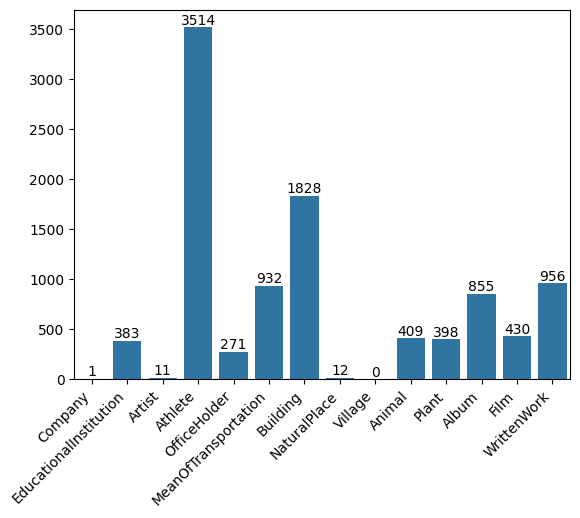

Test on Retain Class
Accuracy: 96.83011770248413
Loss: 0.28806474804878235


In [79]:
from nlp_fast_unlearning.utils import dbpedia_class_dict
import seaborn as sns
from matplotlib import pyplot as plt


print("Test on Forget Class")
history = [evaluate_after_unlearning(unlearning_model, forget_test_dl)]
if history[0]["Acc"]==0:
    print("Yes, accuracy is zero")
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))
pred_counts = history[0]['Count']
ax = sns.barplot(x=np.arange(len(pred_counts)), y=pred_counts)
ax.bar_label(ax.containers[0])
plt.xticks(np.arange(len(pred_counts)),dbpedia_class_dict.values())
plt.xticks(rotation=45, ha='right')
plt.savefig('13_preddist.png', dpi=300,bbox_inches = "tight")
plt.show()

print("Test on Retain Class")
history = [evaluate_after_unlearning(unlearning_model, retain_test_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

In [8]:
baseline_model = TextClassificationModel(vocab_size).to(DEVICE)
baseline_model.load_state_dict(torch.load(baseline_name))

<All keys matched successfully>

In [9]:
print("Baseline test on Forget Class")
history = [evaluate_after_unlearning(baseline_model, forget_test_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

print("Baseline test on Retain Class")
history = [evaluate_after_unlearning(baseline_model, retain_test_dl)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

Baseline test on Forget Class
Accuracy: 95.4882800579071
Loss: 0.15926113724708557
Baseline test on Retain Class
Accuracy: 98.33388328552246
Loss: 0.06146768108010292


In [35]:
import numpy as np

ensure_deterministic()
best_noise = {}
classes_to_forget=[13]

max_noise_token = int(dbpedia_vocab.vocab_size)
search_len = int(dbpedia_vocab.vocab_size * 0.5)
search_space = np.random.permutation(max_noise_token)[:search_len]
baseline_model.train(False)
for class_id in classes_to_forget:
    best_loss = 0
    print("Searching for error maximizing noise for class ", class_id)
    with torch.no_grad():
        for noise_token in search_space:
            inputs = noise_token * torch.ones((1, 100)).long()
            labels = torch.zeros(1).long() + class_id
            labels, inputs, offsets = dbpedia_vocab.collate_batch(zip(labels, inputs))
            outputs = baseline_model(inputs, offsets)
            loss = baseline_model.criterion(outputs, labels)
            if loss.item() > best_loss:
                best_noise[class_id] = inputs
                best_loss = loss.item()
    print(f"Got loss {best_loss} for {best_noise[class_id]}")


Searching for error maximizing noise for class  13
Got loss 228.0972137451172 for tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101], device='cuda:0')


In [36]:
import numpy as np

ensure_deterministic()
best_noise = {}
classes_to_forget=[13]

max_noise_token = int(dbpedia_vocab.vocab_size)
search_len = int(dbpedia_vocab.vocab_size * 0.5)
baseline_model.train(False)
for class_id in classes_to_forget:
    best_loss = 0
    print("Searching for error maximizing noise for class ", class_id)
    with torch.no_grad():
        for _ in range(search_len):
            inputs = torch.randint(low=0, high=max_noise_token, size=(1,100))
            labels = torch.zeros(1).long() + class_id
            labels, inputs, offsets = dbpedia_vocab.collate_batch(zip(labels, inputs))
            outputs = baseline_model(inputs, offsets)
            loss = baseline_model.criterion(outputs, labels)
            if loss.item() > best_loss:
                best_noise[class_id] = inputs
                best_loss = loss.item()
    print(f"Got loss {best_loss} for {best_noise[class_id]}")


Searching for error maximizing noise for class  13
Got loss 7.431220531463623 for tensor([647529, 653034, 719545, 605588, 459021, 671763, 600991, 437676, 475107,
        490243, 246237,   7876, 422932, 378525, 754004, 646097,  94371, 538221,
        534344,  45194, 729873, 795262, 239783, 271755, 541839, 269401, 543542,
        318880, 654918, 239547, 310176, 501957, 679786, 393241, 423611,  33747,
        736763, 112544, 583784, 571262,  93764,   3146,  54487, 733350, 744693,
        643251, 561179, 325649, 388258, 308095, 483803, 743404, 677809, 213021,
        335464, 507610, 190246, 533720, 314529, 559545, 399916, 582102, 251439,
         56049, 698143, 633964, 395213, 732253,  17516, 194201, 749170, 628710,
         62146, 598924, 484945, 297554, 269754, 136337, 449846, 529332, 166697,
        548690, 417641, 191807, 583431, 483162, 261720, 516767, 543050, 644511,
        341653, 498865, 299733, 226766,   9896, 505436, 509060, 318507, 732200,
        517116], device='cuda:0')


In [30]:
with torch.no_grad():
    inputs = torch.zeros((1, 100)).long()
    labels = torch.zeros(1).long() + 13
    labels, inputs, offsets = dbpedia_vocab.collate_batch(zip(labels, inputs))
    outputs = baseline_model(inputs, offsets)
    loss = baseline_model.criterion(outputs, labels)
    print(loss)

tensor(31.5023, device='cuda:0')


In [82]:
from torchtext.datasets import DBpedia

train_split, test_split = DBpedia()

In [92]:
next(iter(train_split))

/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


(1,
 'E. D. Abbott Ltd  Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972.')